<h1><center>Appendix</center></h1>

## 1. Import libraries

In [73]:
import os
import platform
import sys
import sklearn
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import grangercausalitytests

## 2. Read Data 

In [74]:
data_28 = pd.read_csv("28 Jan.csv", delimiter = ',')


data_28['Date-Time'] = data_28['Date-Time'].apply(lambda data: pd.to_datetime(data, infer_datetime_format=True) )
data_28 = data_28.drop(['Unnamed: 0', 'Tick Dir.','num_tick_direction'], 1)






In [75]:
index_names_1 = data_28[(data_28['Type'] == 'Quote') ].index
data_28.drop(index_names_1, inplace=True)

index_names_2 = data_28[(data_28['Bid Price'] > data_28['Ask Price'])].index
data_28.drop(index_names_2, inplace=True)

index_names_3 = data_28[(data_28['Price'] > data_28['Ask Price'])].index
data_28.drop(index_names_3, inplace=True)


#create num tick direction
data_28['diff Price/Bid'] = np.absolute(data_28['Price'] - data_28['Bid Price'])
data_28['diff Price/Ask'] = np.absolute(data_28['Price'] - data_28['Ask Price'])

data_28['Tick Dir'] = 1
data_28.loc[abs(data_28['diff Price/Bid']) < abs(data_28['diff Price/Ask']), 'Tick Dir'] = -1

#Calculate Quote Spread
data_28['Quote spread'] = (data_28['Ask Price'] - data_28['Bid Price'])
#Calculate Mid quote
data_28['Mid quote'] = (data_28['Ask Price'] + data_28['Bid Price'])/2
#Calculate relative Quote Spread
data_28['Relative Quote spread'] = data_28['Quote spread']/data_28['Mid quote']
#Calculate effective spread
data_28['Effective spread'] = np.absolute(2*(data_28['Price']-data_28['Mid quote'])/data_28['Mid quote'])




data_28


,#RIC,Domain,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Date,Exchange_Time,diff Price/Bid,diff Price/Ask,Tick Dir,Quote spread,Mid quote,Relative Quote spread,Effective spread
0,GME.N,Market Price,2021-01-28 09:30:28.291493819-05:00,Trade,289.99,528491.0,345.00,2.0,346.82,6.0,2021-01-28,09:30:28.291493819-05,55.01,56.83,-1,1.82,345.91,0.005261,0.323321
1,GME.N,Market Price,2021-01-28 09:30:28.291493819-05:00,Trade,289.99,0.0,345.00,2.0,346.82,6.0,2021-01-28,09:30:28.291493819-05,55.01,56.83,-1,1.82,345.91,0.005261,0.323321
4,GME.N,Market Price,2021-01-28 09:30:28.376170108-05:00,Trade,289.67,1.0,288.00,1.0,290.00,10.0,2021-01-28,09:30:28.376170108-05,1.67,0.33,1,2.00,289.00,0.006920,0.004637
6,GME.N,Market Price,2021-01-28 09:30:28.384200825-05:00,Trade,289.67,9.0,287.70,1.0,290.00,10.0,2021-01-28,09:30:28.384200825-05,1.97,0.33,1,2.30,288.85,0.007963,0.005678
7,GME.N,Market Price,2021-01-28 09:30:28.395520961-05:00,Trade,289.33,3.0,287.70,1.0,290.00,10.0,2021-01-28,09:30:28.395520961-05,1.63,0.67,1,2.30,288.85,0.007963,0.003324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336170,GME.N,Market Price,2021-01-28 15:59:41.632737339-05:00,Trade,197.44,1.0,197.14,1.0,197.44,136.0,2021-01-28,15:59:41.632737339-05,0.30,0.00,1,0.30,197.29,0.001521,0.001521
336173,GME.N,Market Price,2021-01-28 15:59:41.632737339-05:00,Trade,197.44,1.0,197.14,1.0,197.44,136.0,2021-01-28,15:59:41.632737339-05,0.30,0.00,1,0.30,197.29,0.001521,0.001521
336175,GME.N,Market Price,2021-01-28 15:59:41.692460383-05:00,Trade,197.44,3.0,197.14,1.0,197.44,136.0,2021-01-28,15:59:41.692460383-05,0.30,0.00,1,0.30,197.29,0.001521,0.001521
336176,GME.N,Market Price,2021-01-28 15:59:41.712323204-05:00,Trade,197.44,2.0,197.14,1.0,197.44,136.0,2021-01-28,15:59:41.712323204-05,0.30,0.00,1,0.30,197.29,0.001521,0.001521


## 3. Calculate Quoted spread and Effective Spread and Mid quote

- Calculate Quoted spread and Effective Spread by use the volumn average in each Time interval (10 Seconds).
- Calculate Mid quote by use the last mid quote in each Time interval (10 Seconds).

In [76]:
data_28['Quote_spread_V'] = data_28['Quote spread']*data_28['Volume']
data_28['Relative_Quote_spread_V'] = data_28['Relative Quote spread']*data_28['Volume']
data_28['Effective_spread_V'] = data_28['Effective spread']*data_28['Volume']

In [77]:
Quote_spread_V = data_28.resample('10S', on='Date-Time')['Quote_spread_V'].sum()

Relative_Quote_spread_V = data_28.resample('10S', on='Date-Time')['Relative_Quote_spread_V'].sum()

Effective_spread_V = data_28.resample('10S', on='Date-Time')['Effective_spread_V'].sum()

sum_volume = data_28.resample('10S', on='Date-Time')['Volume'].sum()

last_midquote = data_28.resample('10S', on='Date-Time')['Mid quote'].last()

data_intvl = pd.concat([Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V, sum_volume,first_midquote,last_midquote], 
                       keys=['Quote_spread_V','Relative_Quote_spread_V','Effective_spread_V', 'Volume','first_midquote','last_midquote'], axis=1)

data_intvl
data_intvl = data_intvl.reset_index(level=0)
data_intvl

,Date-Time,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote
0,2021-01-28 09:30:20-05:00,963012.12,2784.730991,170874.955690,567387.0,NaN,270.005
1,2021-01-28 09:30:30-05:00,43567.99,163.071608,149.351158,42516.0,NaN,267.595
2,2021-01-28 09:30:40-05:00,96108.04,355.680090,287.463914,15769.0,NaN,276.570
3,2021-01-28 09:30:50-05:00,88796.03,310.412276,200.736965,13257.0,NaN,291.495
4,2021-01-28 09:31:00-05:00,115695.38,393.872370,202.689798,13382.0,NaN,295.000
...,...,...,...,...,...,...,...
4671,2021-01-29 15:59:10-05:00,NaN,NaN,NaN,NaN,329.475,NaN
4672,2021-01-29 15:59:20-05:00,NaN,NaN,NaN,NaN,329.495,NaN
4673,2021-01-29 15:59:30-05:00,NaN,NaN,NaN,NaN,328.970,NaN
4674,2021-01-29 15:59:40-05:00,NaN,NaN,NaN,NaN,328.235,NaN


In [78]:
# Calculate avverage spread

# Volume average Quoted spread
data_intvl['intvl Quote spread'] = data_intvl['Quote_spread_V']/data_intvl['Volume']
data_intvl['intvl Relative Quote spread'] = data_intvl['Relative_Quote_spread_V']/data_intvl['Volume']
data_intvl['intvl Effective spread'] = data_intvl['Effective_spread_V']/data_intvl['Volume']
data_intvl

,Date-Time,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread
0,2021-01-28 09:30:20-05:00,963012.12,2784.730991,170874.955690,567387.0,NaN,270.005,1.697276,0.004908,0.301161
1,2021-01-28 09:30:30-05:00,43567.99,163.071608,149.351158,42516.0,NaN,267.595,1.024743,0.003836,0.003513
2,2021-01-28 09:30:40-05:00,96108.04,355.680090,287.463914,15769.0,NaN,276.570,6.094745,0.022556,0.018230
3,2021-01-28 09:30:50-05:00,88796.03,310.412276,200.736965,13257.0,NaN,291.495,6.698049,0.023415,0.015142
4,2021-01-28 09:31:00-05:00,115695.38,393.872370,202.689798,13382.0,NaN,295.000,8.645597,0.029433,0.015146
...,...,...,...,...,...,...,...,...,...,...
4671,2021-01-29 15:59:10-05:00,NaN,NaN,NaN,NaN,329.475,NaN,NaN,NaN,NaN
4672,2021-01-29 15:59:20-05:00,NaN,NaN,NaN,NaN,329.495,NaN,NaN,NaN,NaN
4673,2021-01-29 15:59:30-05:00,NaN,NaN,NaN,NaN,328.970,NaN,NaN,NaN,NaN
4674,2021-01-29 15:59:40-05:00,NaN,NaN,NaN,NaN,328.235,NaN,NaN,NaN,NaN


## 4. Visualise the data

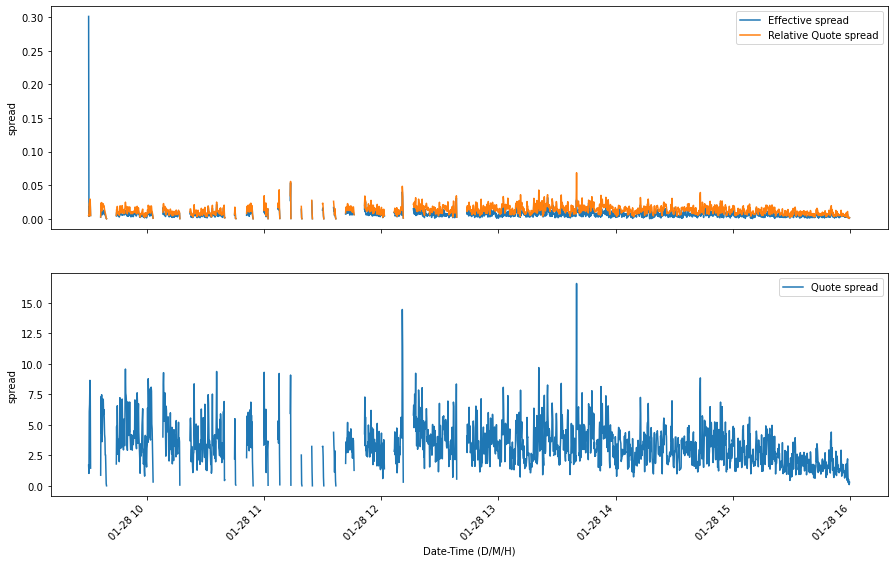

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.autofmt_xdate()
ax[0].plot(data_intvl['Date-Time'], data_intvl['intvl Effective spread'], label = 'Effective spread')
ax[0].plot(data_intvl['Date-Time'],data_intvl['intvl Relative Quote spread'], label = 'Relative Quote spread')
ax[0].legend()
plt.xlabel('Date-Time (D/M/H)')
plt.xticks(rotation=45)
ax[0].set_ylabel('spread')
ax[1].plot(data_intvl['Date-Time'],data_intvl['intvl Quote spread'], label = 'Quote spread')
ax[1].set_ylabel('spread')
ax[1].legend()


## 5. Calculate OIB# and OIB$

In [80]:
data = data_28[['Price', 'Tick Dir', 'Date-Time']]
data = data.groupby('Tick Dir')

num_tick_ = data.resample('10S', on='Date-Time').count()
num_tick_sum = data.resample('10S', on='Date-Time').sum()
data_buyer = num_tick_.loc[1 , :]
data_seller = num_tick_.loc[-1 , :]
No_buyer = data_buyer['Tick Dir']
No_buyer = No_buyer.reset_index(level=0)
No_seller = data_seller['Tick Dir']
No_seller = No_seller.reset_index(level=0)



data_buyer_sum = num_tick_sum.loc[1 , :]
data_seller_sum = num_tick_sum.loc[-1 , :]
dollar_buyer = data_buyer_sum['Price']
dollar_buyer = dollar_buyer.reset_index(level=0)
dollar_seller = data_seller_sum['Price']
dollar_seller = dollar_seller.reset_index(level=0)


In [81]:

data_intvl.insert(1, "No_buyer", No_buyer['Tick Dir'])
data_intvl.insert(1, "No_seller", No_seller['Tick Dir'])
data_intvl.insert(1, "dollar_buyer", dollar_buyer['Price'])
data_intvl.insert(1, "dollar_seller", dollar_seller['Price'])


In [82]:
data_intvl['OIB#'] = (data_intvl['No_buyer']-data_intvl['No_seller'])/(data_intvl['No_buyer']+data_intvl['No_seller'])
data_intvl['OIB$'] = (data_intvl['dollar_buyer']-data_intvl['dollar_seller'])/(data_intvl['dollar_buyer']+data_intvl['dollar_seller'])

In [83]:
data_intvl

,Date-Time,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$
0,2021-01-28 09:30:20-05:00,584566.120,25270.56,2112.0,91.0,963012.12,2784.730991,170874.955690,567387.0,NaN,270.005,1.697276,0.004908,0.301161,-0.917385,-0.917124
1,2021-01-28 09:30:30-05:00,191171.800,51349.37,714.0,191.0,43567.99,163.071608,149.351158,42516.0,NaN,267.595,1.024743,0.003836,0.003513,-0.577901,-0.576537
2,2021-01-28 09:30:40-05:00,76027.385,126524.84,281.0,459.0,96108.04,355.680090,287.463914,15769.0,NaN,276.570,6.094745,0.022556,0.018230,0.240541,0.249306
3,2021-01-28 09:30:50-05:00,83130.710,231465.98,289.0,806.0,88796.03,310.412276,200.736965,13257.0,NaN,291.495,6.698049,0.023415,0.015142,0.472146,0.471509
4,2021-01-28 09:31:00-05:00,178602.060,278770.09,609.0,942.0,115695.38,393.872370,202.689798,13382.0,NaN,295.000,8.645597,0.029433,0.015146,0.214700,0.219008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,2021-01-29 15:59:10-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329.475,NaN,NaN,NaN,NaN,NaN,NaN
4672,2021-01-29 15:59:20-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329.495,NaN,NaN,NaN,NaN,NaN,NaN
4673,2021-01-29 15:59:30-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.970,NaN,NaN,NaN,NaN,NaN,NaN
4674,2021-01-29 15:59:40-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.235,NaN,NaN,NaN,NaN,NaN,NaN


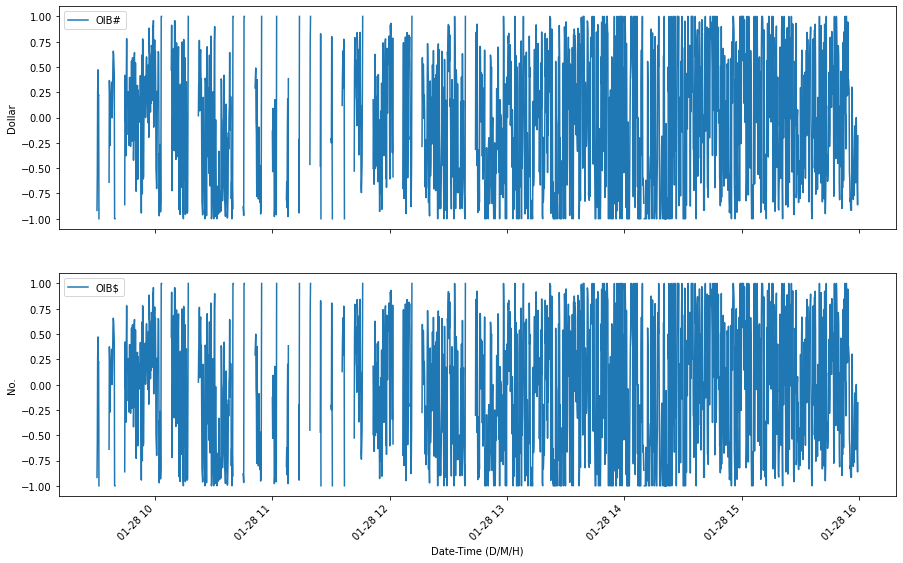

In [84]:


fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.autofmt_xdate()
ax[0].plot(data_intvl['Date-Time'], data_intvl['OIB#'], label = 'OIB#')
ax[0].legend()
plt.xlabel('Date-Time (D/M/H)')
plt.xticks(rotation=45)
ax[0].set_ylabel('Dollar')
ax[1].plot(data_intvl['Date-Time'],data_intvl['OIB$'], label = 'OIB$')
ax[1].set_ylabel('No.')
ax[1].legend()

## 5. Basic Regression

10 seconds returns are computed by using equation 3

In [85]:
# calculate return

data_intvl['Returns'] = (data_intvl['last_midquote']/data_intvl['last_midquote'].shift(1))-1
data_intvl

,Date-Time,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
0,2021-01-28 09:30:20-05:00,584566.120,25270.56,2112.0,91.0,963012.12,2784.730991,170874.955690,567387.0,NaN,270.005,1.697276,0.004908,0.301161,-0.917385,-0.917124,NaN
1,2021-01-28 09:30:30-05:00,191171.800,51349.37,714.0,191.0,43567.99,163.071608,149.351158,42516.0,NaN,267.595,1.024743,0.003836,0.003513,-0.577901,-0.576537,-0.008926
2,2021-01-28 09:30:40-05:00,76027.385,126524.84,281.0,459.0,96108.04,355.680090,287.463914,15769.0,NaN,276.570,6.094745,0.022556,0.018230,0.240541,0.249306,0.033539
3,2021-01-28 09:30:50-05:00,83130.710,231465.98,289.0,806.0,88796.03,310.412276,200.736965,13257.0,NaN,291.495,6.698049,0.023415,0.015142,0.472146,0.471509,0.053965
4,2021-01-28 09:31:00-05:00,178602.060,278770.09,609.0,942.0,115695.38,393.872370,202.689798,13382.0,NaN,295.000,8.645597,0.029433,0.015146,0.214700,0.219008,0.012024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,2021-01-29 15:59:10-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329.475,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4672,2021-01-29 15:59:20-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329.495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4673,2021-01-29 15:59:30-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4674,2021-01-29 15:59:40-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.235,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
#Define low liquidity of intvl effective sprerad < mean effective spread + 1 SD
#0 FOR LOW LIQID DAY, 1 for low liquid

data_intvl['ILD'] = 0
data_intvl.loc[(data_intvl['intvl Effective spread'] > 0.007103+0.008365), 'ILD'] = 1

# Create linear Regression model by using 2 X dimension i.e. OIB$(t-1) and OIB$(t-1)*ILD
X = pd.DataFrame() 
X['OIB'] = data_intvl['OIB$'].shift(1)
X = X.drop(0, 0).reset_index().drop('index',1) 
X['OIBILD'] = X['OIB']*data_intvl['ILD']
X = X[ np.isfinite( X ).all( axis = 1) ]
y = pd.DataFrame()
y['Returns'] = data_intvl['Returns']
y = y[ np.isfinite( y ).all( axis = 1) ]
trn = X.merge(y, left_index=True, right_index=True)

X_train = trn.drop('Returns',1)
y_train = trn["Returns"]





In [87]:
from statsmodels.formula.api import ols
lm1 = ols('Returns~ OIB',data=trn).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     394.8
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           1.85e-79
Time:                        23:34:41   Log-Likelihood:                 5402.4
No. Observations:                1769   AIC:                        -1.080e+04
Df Residuals:                    1767   BIC:                        -1.079e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    7.73e-05      0.000      0.284      0.776      -0.000       0.001
OIB            0.0084      0.000     19.870      0.000       0.008       0.009
==============================================================================
Omnibus:                      353.371   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7305.179
Skew:                          -0.353   Prob(JB):                         0.00
Kurtosis:                      12.930   Cond. No.                         1.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
lm2 = ols('Returns~ OIB+OIBILD',data=trn).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     265.1
Date:                Sun, 10 Apr 2022   Prob (F-statistic):          2.17e-101
Time:                        23:34:41   Log-Likelihood:                 5456.2
No. Observations:                1769   AIC:                        -1.091e+04
Df Residuals:                    1766   BIC:                        -1.089e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004      0.000      1.650      0.099   -8.28e-05       0.001
OIB            0.0072      0.000     16.967      0.000       0.006       0.008
OIBILD         0.0168      0.002     10.524      0.000       0.014       0.020
==============================================================================
Omnibus:                      299.598   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5827.164
Skew:                           0.060   Prob(JB):                         0.00
Kurtosis:                      11.891   Cond. No.                         6.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Granger Causility test


In [89]:
trn = X.merge(data_intvl['intvl Effective spread'], left_index=True, right_index=True)
grangercausalitytests(trn[['OIBILD', 'intvl Effective spread']], maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1962  , p=0.6578  , df_denom=1788, df_num=1
ssr based chi2 test:   chi2=0.1966  , p=0.6575  , df=1
likelihood ratio test: chi2=0.1966  , p=0.6575  , df=1
parameter F test:         F=0.1962  , p=0.6578  , df_denom=1788, df_num=1


{1: ({'ssr_ftest': (0.19623343969486187, 0.6578320261153843, 1788.0, 1),
   'ssr_chi2test': (0.1965626904326049, 0.6575097669938275, 1),
   'lrtest': (0.19655190481262252, 0.6575185638748684, 1),
   'params_ftest': (0.19623343968722953, 0.6578320261217048, 1788.0, 1.0)},
   array([[0., 1., 0.]])])}

In [90]:
grangercausalitytests(trn[['intvl Effective spread','OIBILD' ]], maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9434  , p=0.0049  , df_denom=1788, df_num=1
ssr based chi2 test:   chi2=7.9567  , p=0.0048  , df=1
likelihood ratio test: chi2=7.9391  , p=0.0048  , df=1
parameter F test:         F=7.9434  , p=0.0049  , df_denom=1788, df_num=1


{1: ({'ssr_ftest': (7.943400750624677, 0.004879427980016204, 1788.0, 1),
   'ssr_chi2test': (7.956728604233107, 0.0047908929740595255, 1),
   'lrtest': (7.939106425019418, 0.004837771772242654, 1),
   'params_ftest': (7.94340075062406, 0.0048794279800184834, 1788.0, 1.0)},
   array([[0., 1., 0.]])])}

/pagebreak

# 27 Jan 2021

In [25]:
data = pd.read_csv("27 Jan.csv", delimiter = ',')


data['Date-Time'] = data['Date-Time'].apply(lambda data: pd.to_datetime(data, infer_datetime_format=True) )
data = data.drop(['Unnamed: 0', 'Tick Dir.','num_tick_direction'], 1)






In [26]:
index_names_1 = data[(data['Type'] == 'Quote') ].index
data.drop(index_names_1, inplace=True)

index_names_2 = data[(data['Bid Price'] > data['Ask Price'])].index
data.drop(index_names_2, inplace=True)

index_names_3 = data[(data['Price'] > data['Ask Price'])].index
data.drop(index_names_3, inplace=True)


#create num tick direction
data['diff Price/Bid'] = np.absolute(data['Price'] - data['Bid Price'])
data['diff Price/Ask'] = np.absolute(data['Price'] - data['Ask Price'])

data['Tick Dir'] = 1
data.loc[abs(data['diff Price/Bid']) < abs(data['diff Price/Ask']), 'Tick Dir'] = -1

#Calculate Quote Spread
data['Quote spread'] = (data['Ask Price'] - data['Bid Price'])
#Calculate Mid quote
data['Mid quote'] = (data['Ask Price'] + data['Bid Price'])/2
#Calculate relative Quote Spread
data['Relative Quote spread'] = data['Quote spread']/data['Mid quote']
#Calculate effective spread
data['Effective spread'] = np.absolute(2*(data['Price']-data['Mid quote'])/data['Mid quote'])




data


,#RIC,Domain,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Date,Exchange_Time,diff Price/Bid,diff Price/Ask,Tick Dir,Quote spread,Mid quote,Relative Quote spread,Effective spread
2,GME.N,Market Price,2021-01-27 09:43:51.232058291-05:00,Trade,293.00,1287888.0,275.00,0.0,300.00,0.0,2021-01-27,09:43:51.232058291-05,18.00,7.00,1,25.00,287.500,0.086957,0.038261
3,GME.N,Market Price,2021-01-27 09:43:51.232058291-05:00,Trade,293.00,0.0,275.00,0.0,300.00,0.0,2021-01-27,09:43:51.232058291-05,18.00,7.00,1,25.00,287.500,0.086957,0.038261
5,GME.N,Market Price,2021-01-27 09:43:51.359561817-05:00,Trade,293.35,10.0,292.99,2.0,293.72,3.0,2021-01-27,09:43:51.359561817-05,0.36,0.37,-1,0.73,293.355,0.002488,0.000034
8,GME.N,Market Price,2021-01-27 09:43:51.359561817-05:00,Trade,293.35,2.0,292.99,2.0,293.72,2.0,2021-01-27,09:43:51.359561817-05,0.36,0.37,-1,0.73,293.355,0.002488,0.000034
9,GME.N,Market Price,2021-01-27 09:43:51.359561817-05:00,Trade,293.35,31.0,292.99,2.0,293.72,2.0,2021-01-27,09:43:51.359561817-05,0.36,0.37,-1,0.73,293.355,0.002488,0.000034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370310,GME.N,Market Price,2021-01-27 15:59:59.880443607-05:00,Trade,345.00,97.0,345.00,4.0,347.02,1.0,2021-01-27,15:59:59.880443607-05,0.00,2.02,-1,2.02,346.010,0.005838,0.005838
370313,GME.N,Market Price,2021-01-27 15:59:59.884220244-05:00,Trade,345.00,16.0,345.00,2.0,347.02,1.0,2021-01-27,15:59:59.884220244-05,0.00,2.02,-1,2.02,346.010,0.005838,0.005838
370315,GME.N,Market Price,2021-01-27 15:59:59.884220244-05:00,Trade,345.00,1.0,345.00,2.0,347.02,1.0,2021-01-27,15:59:59.884220244-05,0.00,2.02,-1,2.02,346.010,0.005838,0.005838
370332,GME.N,Market Price,2021-01-27 15:59:59.972914471-05:00,Trade,345.00,3.0,345.00,2.0,346.87,1.0,2021-01-27,15:59:59.972914471-05,0.00,1.87,-1,1.87,345.935,0.005406,0.005406


## Calculate Quoted spread and Effective Spread by use the volumn average in each Time interval (1 Seconds)

In [27]:
data['Quote_spread_V'] = data['Quote spread']*data['Volume']
data['Relative_Quote_spread_V'] = data['Relative Quote spread']*data['Volume']
data['Effective_spread_V'] = data['Effective spread']*data['Volume']

In [28]:
Quote_spread_V = data.resample('10S', on='Date-Time')['Quote_spread_V'].sum()

Relative_Quote_spread_V = data.resample('10S', on='Date-Time')['Relative_Quote_spread_V'].sum()

Effective_spread_V = data.resample('10S', on='Date-Time')['Effective_spread_V'].sum()

sum_volume = data.resample('10S', on='Date-Time')['Volume'].sum()

first_midquote = data.resample('10S', on='Date-Time')['Mid quote'].first()

last_midquote = data.resample('10S', on='Date-Time')['Mid quote'].last()

data_intvl = pd.concat([Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V, sum_volume,first_midquote,last_midquote], 
                       keys=['Quote_spread_V','Relative_Quote_spread_V','Effective_spread_V', 'Volume','first_midquote','last_midquote'], axis=1)

data_intvl
data_intvl = data_intvl.reset_index(level=0)
# data_intvl['Quote Spread']
data_intvl

,Date-Time,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote
0,2021-01-27 09:43:50-05:00,33827962.19,117428.012502,54555.433604,1533799.0,287.500,307.000
1,2021-01-27 09:44:00-05:00,195476.81,639.333753,571.686544,26233.0,307.000,310.960
2,2021-01-27 09:44:10-05:00,124540.11,397.249834,367.456952,35530.0,310.960,317.535
3,2021-01-27 09:44:20-05:00,144638.70,452.929426,386.904820,51490.0,317.535,314.170
4,2021-01-27 09:44:30-05:00,46894.53,149.359187,73.415828,4037.0,314.170,313.415
...,...,...,...,...,...,...,...
2252,2021-01-27 15:59:10-05:00,17988.11,51.618839,37.529442,23632.0,349.125,349.220
2253,2021-01-27 15:59:20-05:00,11072.04,31.666026,24.747892,26682.0,349.375,349.850
2254,2021-01-27 15:59:30-05:00,22395.09,64.123909,45.835966,28696.0,349.850,348.150
2255,2021-01-27 15:59:40-05:00,50352.34,144.437982,112.996243,30273.0,348.150,349.630


In [29]:
# Calculate avg spread

# Volume avg Quoted spread
data_intvl['intvl Quote spread'] = data_intvl['Quote_spread_V']/data_intvl['Volume']
data_intvl['intvl Relative Quote spread'] = data_intvl['Relative_Quote_spread_V']/data_intvl['Volume']
data_intvl['intvl Effective spread'] = data_intvl['Effective_spread_V']/data_intvl['Volume']
data_intvl

,Date-Time,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread
0,2021-01-27 09:43:50-05:00,33827962.19,117428.012502,54555.433604,1533799.0,287.500,307.000,22.055016,0.076560,0.035569
1,2021-01-27 09:44:00-05:00,195476.81,639.333753,571.686544,26233.0,307.000,310.960,7.451561,0.024371,0.021793
2,2021-01-27 09:44:10-05:00,124540.11,397.249834,367.456952,35530.0,310.960,317.535,3.505210,0.011181,0.010342
3,2021-01-27 09:44:20-05:00,144638.70,452.929426,386.904820,51490.0,317.535,314.170,2.809064,0.008796,0.007514
4,2021-01-27 09:44:30-05:00,46894.53,149.359187,73.415828,4037.0,314.170,313.415,11.616183,0.036998,0.018186
...,...,...,...,...,...,...,...,...,...,...
2252,2021-01-27 15:59:10-05:00,17988.11,51.618839,37.529442,23632.0,349.125,349.220,0.761176,0.002184,0.001588
2253,2021-01-27 15:59:20-05:00,11072.04,31.666026,24.747892,26682.0,349.375,349.850,0.414963,0.001187,0.000928
2254,2021-01-27 15:59:30-05:00,22395.09,64.123909,45.835966,28696.0,349.850,348.150,0.780425,0.002235,0.001597
2255,2021-01-27 15:59:40-05:00,50352.34,144.437982,112.996243,30273.0,348.150,349.630,1.663276,0.004771,0.003733


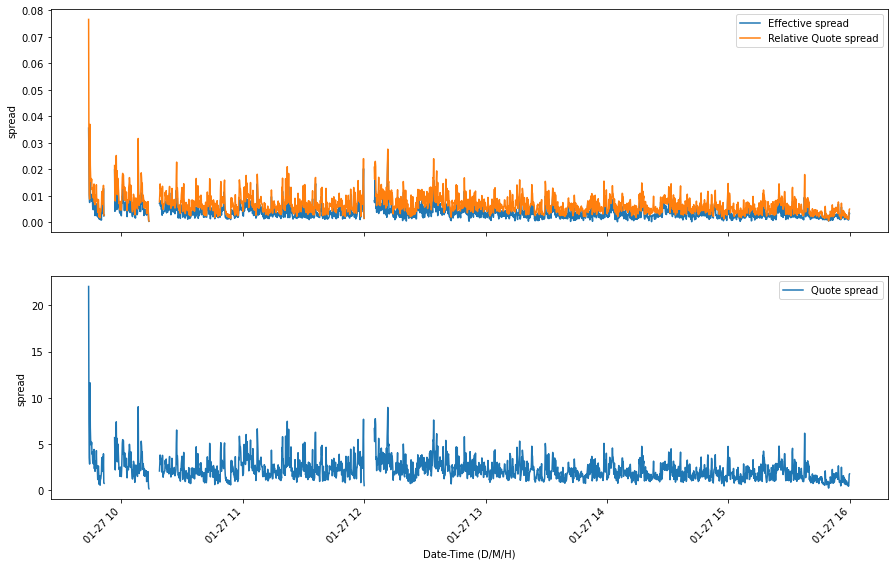

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.autofmt_xdate()
ax[0].plot(data_intvl['Date-Time'], data_intvl['intvl Effective spread'], label = 'Effective spread')
ax[0].plot(data_intvl['Date-Time'],data_intvl['intvl Relative Quote spread'], label = 'Relative Quote spread')
ax[0].legend()
plt.xlabel('Date-Time (D/M/H)')
plt.xticks(rotation=45)
ax[0].set_ylabel('spread')
ax[1].plot(data_intvl['Date-Time'],data_intvl['intvl Quote spread'], label = 'Quote spread')
ax[1].set_ylabel('spread')
ax[1].legend()


## Market efficiency Proxy

In [31]:
data2 = data[['Price', 'Tick Dir', 'Date-Time']]
data2 = data2.groupby('Tick Dir')
num_tick_ = data2.resample('10S', on='Date-Time').count()
num_tick_sum = data2.resample('10S', on='Date-Time').sum()
num_tick_sum
data_buyer = num_tick_.loc[1 , :]
data_seller = num_tick_.loc[-1 , :]
No_buyer = data_buyer['Tick Dir']
No_buyer = No_buyer.reset_index(level=0)
No_seller = data_seller['Tick Dir']
No_seller = No_seller.reset_index(level=0)
No_seller


data_buyer_sum = num_tick_sum.loc[1 , :]
data_seller_sum = num_tick_sum.loc[-1 , :]
dollar_buyer = data_buyer_sum['Price']
dollar_buyer = dollar_buyer.reset_index(level=0)
dollar_seller = data_seller_sum['Price']
dollar_seller = dollar_seller.reset_index(level=0)


In [32]:

data_intvl.insert(1, "No_buyer", No_buyer['Tick Dir'])
data_intvl.insert(1, "No_seller", No_seller['Tick Dir'])
data_intvl.insert(1, "dollar_buyer", dollar_buyer['Price'])
data_intvl.insert(1, "dollar_seller", dollar_seller['Price'])


In [33]:
data_intvl['OIB#'] = (data_intvl['No_buyer']-data_intvl['No_seller'])/(data_intvl['No_buyer']+data_intvl['No_seller'])
data_intvl['OIB$'] = (data_intvl['dollar_buyer']-data_intvl['dollar_seller'])/(data_intvl['dollar_buyer']+data_intvl['dollar_seller'])

In [34]:
data_intvl

,Date-Time,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$
0,2021-01-27 09:43:50-05:00,14768.150,409496.220,49,1368,33827962.19,117428.012502,54555.433604,1533799.0,287.500,307.000,22.055016,0.076560,0.035569,0.930840,0.930382
1,2021-01-27 09:44:00-05:00,41226.000,97850.820,136,317,195476.81,639.333753,571.686544,26233.0,307.000,310.960,7.451561,0.024371,0.021793,0.399558,0.407148
2,2021-01-27 09:44:10-05:00,23336.510,119680.120,74,379,124540.11,397.249834,367.456952,35530.0,310.960,317.535,3.505210,0.011181,0.010342,0.673289,0.673653
3,2021-01-27 09:44:20-05:00,55616.065,102192.645,175,317,144638.70,452.929426,386.904820,51490.0,317.535,314.170,2.809064,0.008796,0.007514,0.288618,0.295146
4,2021-01-27 09:44:30-05:00,9013.820,23783.745,29,75,46894.53,149.359187,73.415828,4037.0,314.170,313.415,11.616183,0.036998,0.018186,0.442308,0.450336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,2021-01-27 15:59:10-05:00,60226.760,30653.075,173,88,17988.11,51.618839,37.529442,23632.0,349.125,349.220,0.761176,0.002184,0.001588,-0.325670,-0.325415
2253,2021-01-27 15:59:20-05:00,51052.415,49316.105,146,141,11072.04,31.666026,24.747892,26682.0,349.375,349.850,0.414963,0.001187,0.000928,-0.017422,-0.017299
2254,2021-01-27 15:59:30-05:00,79191.525,30039.040,227,86,22395.09,64.123909,45.835966,28696.0,349.850,348.150,0.780425,0.002235,0.001597,-0.450479,-0.449988
2255,2021-01-27 15:59:40-05:00,45961.775,76121.525,132,218,50352.34,144.437982,112.996243,30273.0,348.150,349.630,1.663276,0.004771,0.003733,0.245714,0.247042


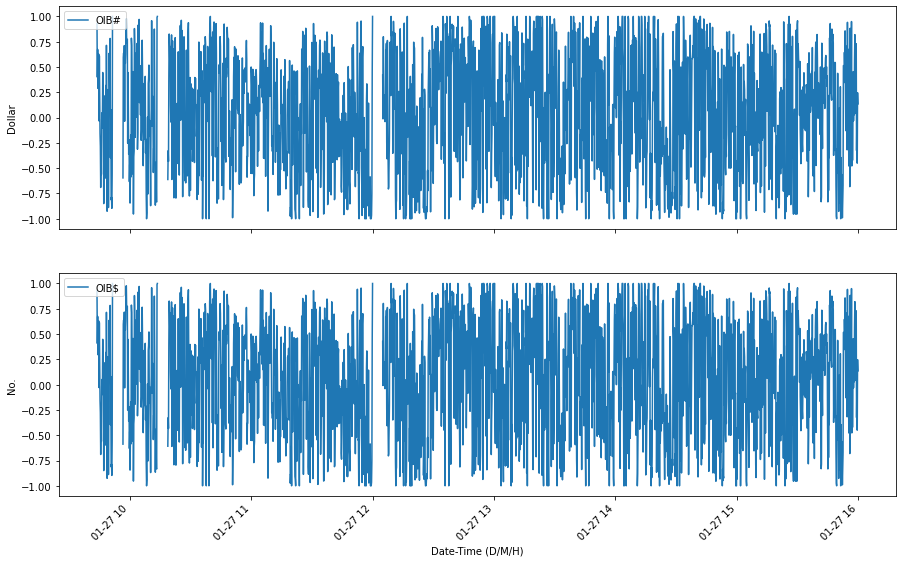

In [35]:
# plt.figure(figsize=(25,5))
# plt.plot(data_intvl['Date-Time'], data_intvl['OIB#'], label = 'OIB#')
# plt.plot(data_intvl['Date-Time'],data_intvl['OIB$'], label = 'OIB$')
# plt.legend()

fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.autofmt_xdate()
ax[0].plot(data_intvl['Date-Time'], data_intvl['OIB#'], label = 'OIB#')
ax[0].legend()
plt.xlabel('Date-Time (D/M/H)')
plt.xticks(rotation=45)
ax[0].set_ylabel('Dollar')
ax[1].plot(data_intvl['Date-Time'],data_intvl['OIB$'], label = 'OIB$')
ax[1].set_ylabel('No.')
ax[1].legend()

## Variance ratio

## Basic Regression

10 seconds returns are computed using the midpoints of the first and last quotes within each 10 seconds trading interval

In [36]:
# calculate return
# data_intvl['Returns'] = data_intvl['first_midquote']-data_intvl['last_midquote']
data_intvl['Returns'] = (data_intvl['last_midquote']/data_intvl['last_midquote'].shift(1))-1
data_intvl

,Date-Time,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
0,2021-01-27 09:43:50-05:00,14768.150,409496.220,49,1368,33827962.19,117428.012502,54555.433604,1533799.0,287.500,307.000,22.055016,0.076560,0.035569,0.930840,0.930382,NaN
1,2021-01-27 09:44:00-05:00,41226.000,97850.820,136,317,195476.81,639.333753,571.686544,26233.0,307.000,310.960,7.451561,0.024371,0.021793,0.399558,0.407148,0.012899
2,2021-01-27 09:44:10-05:00,23336.510,119680.120,74,379,124540.11,397.249834,367.456952,35530.0,310.960,317.535,3.505210,0.011181,0.010342,0.673289,0.673653,0.021144
3,2021-01-27 09:44:20-05:00,55616.065,102192.645,175,317,144638.70,452.929426,386.904820,51490.0,317.535,314.170,2.809064,0.008796,0.007514,0.288618,0.295146,-0.010597
4,2021-01-27 09:44:30-05:00,9013.820,23783.745,29,75,46894.53,149.359187,73.415828,4037.0,314.170,313.415,11.616183,0.036998,0.018186,0.442308,0.450336,-0.002403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,2021-01-27 15:59:10-05:00,60226.760,30653.075,173,88,17988.11,51.618839,37.529442,23632.0,349.125,349.220,0.761176,0.002184,0.001588,-0.325670,-0.325415,0.000272
2253,2021-01-27 15:59:20-05:00,51052.415,49316.105,146,141,11072.04,31.666026,24.747892,26682.0,349.375,349.850,0.414963,0.001187,0.000928,-0.017422,-0.017299,0.001804
2254,2021-01-27 15:59:30-05:00,79191.525,30039.040,227,86,22395.09,64.123909,45.835966,28696.0,349.850,348.150,0.780425,0.002235,0.001597,-0.450479,-0.449988,-0.004859
2255,2021-01-27 15:59:40-05:00,45961.775,76121.525,132,218,50352.34,144.437982,112.996243,30273.0,348.150,349.630,1.663276,0.004771,0.003733,0.245714,0.247042,0.004251


### Descriptive statistics

In [37]:
# data_intvl = data_intvl[ np.isfinite( data_intvl ).all( axis = 1) ]
data_intvl.describe(include='float64')



,dollar_seller,dollar_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
count,2257.000000,2257.000000,2.257000e+03,2257.000000,2257.000000,2.257000e+03,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2168.000000,2164.000000
mean,15249.682549,16476.199311,2.398642e+04,79.810784,42.813100,4.660619e+03,327.533519,327.542401,2.207127,0.006784,0.003909,0.053379,0.054120,0.000055
std,23686.157208,21180.958259,7.120268e+05,2471.652083,1148.661707,3.272930e+04,23.141739,23.146582,1.208174,0.003843,0.002679,0.575187,0.575166,0.007732
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,249.620000,249.660000,0.129087,0.000517,0.000256,-1.000000,-1.000000,-0.063958
25%,3174.620000,3676.400000,1.877510e+03,5.743033,2.744636,1.056000e+03,316.022500,316.223750,1.426555,0.004315,0.002151,-0.405518,-0.403756,-0.002872
50%,8809.410000,9600.830000,4.397610e+03,13.491325,7.290298,2.353000e+03,328.627500,328.587500,1.950559,0.006038,0.003203,0.100000,0.101322,0.000131
75%,18921.580000,21317.610000,9.916650e+03,30.287966,18.897817,4.711000e+03,341.758750,341.771250,2.718580,0.008325,0.004888,0.525464,0.526610,0.003095
max,392720.960000,409496.220000,3.382796e+07,117428.012502,54555.433604,1.533799e+06,379.020000,378.560000,22.055016,0.076560,0.035569,1.000000,1.000000,0.066003


In [38]:
# plt.figure(figsize = (10,8))
# sns.heatmap(, vmax= 1, vmin =-1, annot = True)

data_intvl.corr()

,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
dollar_seller,1.000000,0.159567,0.991394,0.157567,0.013531,0.012340,0.021356,0.105940,0.007891,-0.044374,0.186223,0.183216,0.293581,-0.411652,-0.411473,-0.491961
dollar_buyer,0.159567,1.000000,0.142919,0.993116,0.399218,0.398252,0.402115,0.467411,0.048803,0.090511,0.182093,0.192521,0.191096,0.420080,0.420365,0.359233
No_seller,0.991394,0.142919,1.000000,0.147330,0.014015,0.013075,0.022127,0.104970,-0.061109,-0.111271,0.173961,0.181772,0.291548,-0.393927,-0.393746,-0.478720
No_buyer,0.157567,0.993116,0.147330,1.000000,0.433098,0.432269,0.436314,0.499256,-0.030336,0.011753,0.199327,0.221420,0.215943,0.417062,0.417354,0.366284
Quote_spread_V,0.013531,0.399218,0.014015,0.433098,1.000000,0.999996,0.999884,0.986645,-0.037665,-0.020040,0.361764,0.398836,0.265852,0.030548,0.030513,-0.189003
Relative_Quote_spread_V,0.012340,0.398252,0.013075,0.432269,0.999996,1.000000,0.999865,0.986397,-0.038793,-0.021109,0.360825,0.398124,0.264883,0.030753,0.030718,-0.183717
Effective_spread_V,0.021356,0.402115,0.022127,0.436314,0.999884,0.999865,1.000000,0.987896,-0.040264,-0.022934,0.364838,0.402321,0.273009,0.029093,0.029062,-0.190209
Volume,0.105940,0.467411,0.104970,0.499256,0.986645,0.986397,0.987896,1.000000,-0.038090,-0.022402,0.353804,0.391339,0.286480,0.024126,0.024118,-0.110362
first_midquote,0.007891,0.048803,-0.061109,-0.030336,-0.037665,-0.038793,-0.040264,-0.038090,1.000000,0.994097,-0.026216,-0.162901,-0.162552,-0.030306,-0.030408,-0.045067
last_midquote,-0.044374,0.090511,-0.111271,0.011753,-0.020040,-0.021109,-0.022934,-0.022402,0.994097,1.000000,-0.031547,-0.166667,-0.174140,0.023389,0.023292,0.060386


In [39]:

#Define low liquidity of intvl effective sprerad < mean effective spread 

data_intvl['ILD'] = 0
data_intvl.loc[(data_intvl['intvl Effective spread'] > 0.003909+0.002679), 'ILD'] = 1

# # Create linear Regression model by using 2 X dimension i.e. OIB$(t-1) and OIB$(t-1)*ILD
# X = pd.DataFrame() 
# X['OIBS'] = data_intvl['OIB$'].shift(1)
# X['OIB'] = data_intvl['OIB#'].shift(1)
# X = X.drop(0, 0).reset_index().drop('index',1) 
# X['OIBSILD'] = X['OIBS']*data_intvl['ILD']
# X.dropna(inplace=True)
# X = X[ np.isfinite( X ).all( axis = 1) ]
# y = pd.DataFrame()
# y['Returns'] = data_intvl['Returns']
# y = y[ np.isfinite( y ).all( axis = 1) ]
# trn = X.merge(y, left_index=True, right_index=True)

# X_train = trn.drop('Returns',1)
# y_train = trn["Returns"]

# Create linear Regression model by using 2 X dimension i.e. OIB$(t-1) and OIB$(t-1)*ILD
X = pd.DataFrame() 
X['OIB'] = data_intvl['OIB$'].shift(1)
X = X.drop(0, 0).reset_index().drop('index',1) 
X['OIBILD'] = X['OIB']*data_intvl['ILD']
X = X[ np.isfinite( X ).all( axis = 1) ]
y = pd.DataFrame()
y['Returns'] = data_intvl['Returns']
y = y[ np.isfinite( y ).all( axis = 1) ]
trn = X.merge(y, left_index=True, right_index=True)

X_train = trn.drop('Returns',1)
y_train = trn["Returns"]


#Create linear regression model

linr =  LinearRegression().fit(X_train, y_train)
r_square = linr.score(X_train, y_train)
r_square

#Create linear regression model

# linr =  LinearRegression().fit(X_train, y_train)
# r_square = linr.score(X_train, y_train)
# r_square

X


,OIB,OIBILD
0,0.930382,0.930382
1,0.407148,0.407148
2,0.673653,0.673653
3,0.295146,0.295146
4,0.450336,0.450336
...,...,...
2251,0.729594,0.000000
2252,-0.325415,-0.000000
2253,-0.017299,-0.000000
2254,-0.449988,-0.000000


In [40]:
# CALCULATE the ESPR in liquid and illiquidity day
data_intvl.groupby('ILD').mean()


,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
ILD,,,,,,,,,,,,,,,,
0,13178.776372,15789.925803,40.377016,47.753528,6430.775494,19.622010,12.015349,3589.035786,328.559417,328.673269,1.931600,0.005900,0.003143,0.087468,0.088134,0.000401
1,30299.784575,21463.622905,96.208791,68.344322,151570.285714,517.226634,266.632646,12448.245421,320.412363,319.692601,4.119672,0.012922,0.009223,-0.183242,-0.181979,-0.002381


In [41]:
data_intvl.groupby('ILD').std()

,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
ILD,,,,,,,,,,,,,,,,
0,19725.758747,18471.821750,65.843424,54.929701,8.954461e+03,27.782960,20.488157,5526.187070,22.578692,22.600542,0.806419,0.002474,0.001427,0.549724,0.549669,0.006333
1,39470.380397,34713.907241,128.534773,114.260500,2.045923e+06,7102.478994,3298.969144,92697.523008,25.661881,25.316365,1.703153,0.005634,0.003250,0.683534,0.683908,0.013868


In [42]:
data_intvl.groupby('ILD').count()

,Date-Time,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
ILD,,,,,,,,,,,,,,,,,
0,1984,1984,1984,1984,1984,1984,1984,1984,1984,1895,1895,1895,1895,1895,1895,1895,1895
1,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,269


In [43]:
from statsmodels.formula.api import ols
lm1 = ols('Returns~ OIB',data=trn).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     701.2
Date:                Sat, 09 Apr 2022   Prob (F-statistic):          4.65e-134
Time:                        20:30:20   Log-Likelihood:                 7752.9
No. Observations:                2163   AIC:                        -1.550e+04
Df Residuals:                    2161   BIC:                        -1.549e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0003      0.000     -2.065      0.039      -0.001    -1.5e-05
OIB            0.0067      0.000     26.480      0.000       0.006       0.007
==============================================================================
Omnibus:                      474.965   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18632.888
Skew:                          -0.131   Prob(JB):                         0.00
Kurtosis:                      17.376   Cond. No.                         1.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
lm2 = ols('Returns~ OIB+OIBILD',data=trn).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     403.0
Date:                Sat, 09 Apr 2022   Prob (F-statistic):          1.82e-149
Time:                        20:30:20   Log-Likelihood:                 7792.0
No. Observations:                2163   AIC:                        -1.558e+04
Df Residuals:                    2160   BIC:                        -1.556e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0001      0.000     -0.760      0.447      -0.000       0.000
OIB            0.0056      0.000     20.191      0.000       0.005       0.006
OIBILD         0.0057      0.001      8.910      0.000       0.004       0.007
==============================================================================
Omnibus:                      454.716   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15606.114
Skew:                          -0.127   Prob(JB):                         0.00
Kurtosis:                      16.157   Cond. No.                         4.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
trn = X.merge(data_intvl['intvl Effective spread'], left_index=True, right_index=True)
trn
# test if the intvl Effective spread is predictive of the future OIB$ in (100s)
grangercausalitytests(trn[['OIBILD', 'intvl Effective spread']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2548  , p=0.0129  , df_denom=2136, df_num=10
ssr based chi2 test:   chi2=22.7699 , p=0.0116  , df=10
likelihood ratio test: chi2=22.6505 , p=0.0121  , df=10
parameter F test:         F=2.2548  , p=0.0129  , df_denom=2136, df_num=10


{10: ({'ssr_ftest': (2.254820502925924, 0.012872689277143608, 2136.0, 10),
   'ssr_chi2test': (22.76988682027724, 0.011628583980774243, 10),
   'lrtest': (22.650543365003614, 0.012112630234408483, 10),
   'params_ftest': (2.254820502925436, 0.012872689277164692, 2136.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    

In [46]:
grangercausalitytests(trn[['intvl Effective spread','OIBILD' ]], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3789  , p=0.0084  , df_denom=2136, df_num=10
ssr based chi2 test:   chi2=24.0231 , p=0.0075  , df=10
likelihood ratio test: chi2=23.8903 , p=0.0079  , df=10
parameter F test:         F=2.3789  , p=0.0084  , df_denom=2136, df_num=10


{10: ({'ssr_ftest': (2.378917973786991, 0.008432127864915089, 2136.0, 10),
   'ssr_chi2test': (24.023062122933236, 0.007539411616577331, 10),
   'lrtest': (23.8902716593293, 0.0078970303751707, 10),
   'params_ftest': (2.3789179737867534, 0.008432127864922584, 2136.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

# 29 Jan 2021

In [47]:
data = pd.read_csv("29 Jan.csv", delimiter = ',')


data['Date-Time'] = data['Date-Time'].apply(lambda data: pd.to_datetime(data, infer_datetime_format=True) )
data = data.drop(['Unnamed: 0', 'Tick Dir.','num_tick_direction'], 1)






In [48]:
index_names_1 = data[(data['Type'] == 'Quote') ].index
data.drop(index_names_1, inplace=True)

index_names_2 = data[(data['Bid Price'] > data['Ask Price'])].index
data.drop(index_names_2, inplace=True)

index_names_3 = data[(data['Price'] > data['Ask Price'])].index
data.drop(index_names_3, inplace=True)


#create num tick direction
data['diff Price/Bid'] = np.absolute(data['Price'] - data['Bid Price'])
data['diff Price/Ask'] = np.absolute(data['Price'] - data['Ask Price'])

data['Tick Dir'] = 1
data.loc[abs(data['diff Price/Bid']) < abs(data['diff Price/Ask']), 'Tick Dir'] = -1



#Calculate Quote Spread
data['Quote spread'] = (data['Ask Price'] - data['Bid Price'])
#Calculate Mid quote
data['Mid quote'] = (data['Ask Price'] + data['Bid Price'])/2
#Calculate relative Quote Spread
data['Relative Quote spread'] = data['Quote spread']/data['Mid quote']
#Calculate effective spread
data['Effective spread'] = np.absolute(2*(data['Price']-data['Mid quote'])/data['Mid quote'])




data


,#RIC,Domain,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Date,Exchange_Time,diff Price/Bid,diff Price/Ask,Tick Dir,Quote spread,Mid quote,Relative Quote spread,Effective spread
3,GME.N,Market Price,2021-01-29 09:30:11.790758682-05:00,Trade,380.0,4.0,379.97,1.0,380.00,6.0,2021-01-29,09:30:11.790758682-05,0.03,0.00,1,0.03,379.985,0.000079,0.000079
4,GME.N,Market Price,2021-01-29 09:30:11.790758682-05:00,Trade,380.0,5.0,379.97,1.0,380.00,6.0,2021-01-29,09:30:11.790758682-05,0.03,0.00,1,0.03,379.985,0.000079,0.000079
5,GME.N,Market Price,2021-01-29 09:30:11.790758682-05:00,Trade,380.0,1.0,379.97,1.0,380.00,6.0,2021-01-29,09:30:11.790758682-05,0.03,0.00,1,0.03,379.985,0.000079,0.000079
6,GME.N,Market Price,2021-01-29 09:30:11.790758682-05:00,Trade,380.0,1.0,379.97,1.0,380.00,6.0,2021-01-29,09:30:11.790758682-05,0.03,0.00,1,0.03,379.985,0.000079,0.000079
7,GME.N,Market Price,2021-01-29 09:30:11.790758682-05:00,Trade,380.0,2.0,379.97,1.0,380.00,6.0,2021-01-29,09:30:11.790758682-05,0.03,0.00,1,0.03,379.985,0.000079,0.000079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332342,GME.N,Market Price,2021-01-29 15:59:59.875667050-05:00,Trade,328.0,15.0,328.00,23.0,328.48,1.0,2021-01-29,15:59:59.875667050-05,0.00,0.48,-1,0.48,328.240,0.001462,0.001462
332344,GME.N,Market Price,2021-01-29 15:59:59.887567967-05:00,Trade,328.0,10.0,328.00,23.0,328.48,1.0,2021-01-29,15:59:59.887567967-05,0.00,0.48,-1,0.48,328.240,0.001462,0.001462
332345,GME.N,Market Price,2021-01-29 15:59:59.936339122-05:00,Trade,328.0,1.0,328.00,23.0,328.48,1.0,2021-01-29,15:59:59.936339122-05,0.00,0.48,-1,0.48,328.240,0.001462,0.001462
332348,GME.N,Market Price,2021-01-29 15:59:59.952164056-05:00,Trade,328.0,10.0,328.00,23.0,328.48,1.0,2021-01-29,15:59:59.952164056-05,0.00,0.48,-1,0.48,328.240,0.001462,0.001462


## Calculate Quoted spread and Effective Spread by use the volumn average in each Time interval (1 Seconds)

In [49]:
data['Quote_spread_V'] = data['Quote spread']*data['Volume']
data['Relative_Quote_spread_V'] = data['Relative Quote spread']*data['Volume']
data['Effective_spread_V'] = data['Effective spread']*data['Volume']

In [50]:
Quote_spread_V = data.resample('10S', on='Date-Time')['Quote_spread_V'].sum()

Relative_Quote_spread_V = data.resample('10S', on='Date-Time')['Relative_Quote_spread_V'].sum()

Effective_spread_V = data.resample('10S', on='Date-Time')['Effective_spread_V'].sum()

sum_volume = data.resample('10S', on='Date-Time')['Volume'].sum()

first_midquote = data.resample('10S', on='Date-Time')['Mid quote'].first()

last_midquote = data.resample('10S', on='Date-Time')['Mid quote'].last()

data_intvl = pd.concat([Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V, sum_volume,first_midquote,last_midquote], 
                       keys=['Quote_spread_V','Relative_Quote_spread_V','Effective_spread_V', 'Volume','first_midquote','last_midquote'], axis=1)

data_intvl
data_intvl = data_intvl.reset_index(level=0)
# data_intvl['Quote Spread']
data_intvl

,Date-Time,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote
0,2021-01-29 09:30:10-05:00,44310.00,116.528550,72.554008,14975.0,379.985,381.120
1,2021-01-29 09:30:20-05:00,224082.95,581.999008,485.749662,36575.0,381.120,391.410
2,2021-01-29 09:30:30-05:00,78377.35,198.914580,136.205062,21722.0,392.910,389.975
3,2021-01-29 09:30:40-05:00,83197.56,210.454723,154.037134,12686.0,389.975,397.225
4,2021-01-29 09:30:50-05:00,15624.23,39.374157,18.124133,7610.0,397.225,393.475
...,...,...,...,...,...,...,...
2334,2021-01-29 15:59:10-05:00,7350.05,22.323057,16.168743,10013.0,329.475,328.995
2335,2021-01-29 15:59:20-05:00,6768.06,20.546515,16.514068,10960.0,329.495,328.970
2336,2021-01-29 15:59:30-05:00,15623.27,47.562471,39.606714,19954.0,328.970,328.235
2337,2021-01-29 15:59:40-05:00,1670.53,5.083719,2.356957,3751.0,328.235,328.495


In [51]:
# Calculate avg spread

# Volume avg Quoted spread
data_intvl['intvl Quote spread'] = data_intvl['Quote_spread_V']/data_intvl['Volume']
data_intvl['intvl Relative Quote spread'] = data_intvl['Relative_Quote_spread_V']/data_intvl['Volume']
data_intvl['intvl Effective spread'] = data_intvl['Effective_spread_V']/data_intvl['Volume']
data_intvl

,Date-Time,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread
0,2021-01-29 09:30:10-05:00,44310.00,116.528550,72.554008,14975.0,379.985,381.120,2.958932,0.007782,0.004845
1,2021-01-29 09:30:20-05:00,224082.95,581.999008,485.749662,36575.0,381.120,391.410,6.126670,0.015912,0.013281
2,2021-01-29 09:30:30-05:00,78377.35,198.914580,136.205062,21722.0,392.910,389.975,3.608201,0.009157,0.006270
3,2021-01-29 09:30:40-05:00,83197.56,210.454723,154.037134,12686.0,389.975,397.225,6.558219,0.016590,0.012142
4,2021-01-29 09:30:50-05:00,15624.23,39.374157,18.124133,7610.0,397.225,393.475,2.053118,0.005174,0.002382
...,...,...,...,...,...,...,...,...,...,...
2334,2021-01-29 15:59:10-05:00,7350.05,22.323057,16.168743,10013.0,329.475,328.995,0.734051,0.002229,0.001615
2335,2021-01-29 15:59:20-05:00,6768.06,20.546515,16.514068,10960.0,329.495,328.970,0.617524,0.001875,0.001507
2336,2021-01-29 15:59:30-05:00,15623.27,47.562471,39.606714,19954.0,328.970,328.235,0.782964,0.002384,0.001985
2337,2021-01-29 15:59:40-05:00,1670.53,5.083719,2.356957,3751.0,328.235,328.495,0.445356,0.001355,0.000628


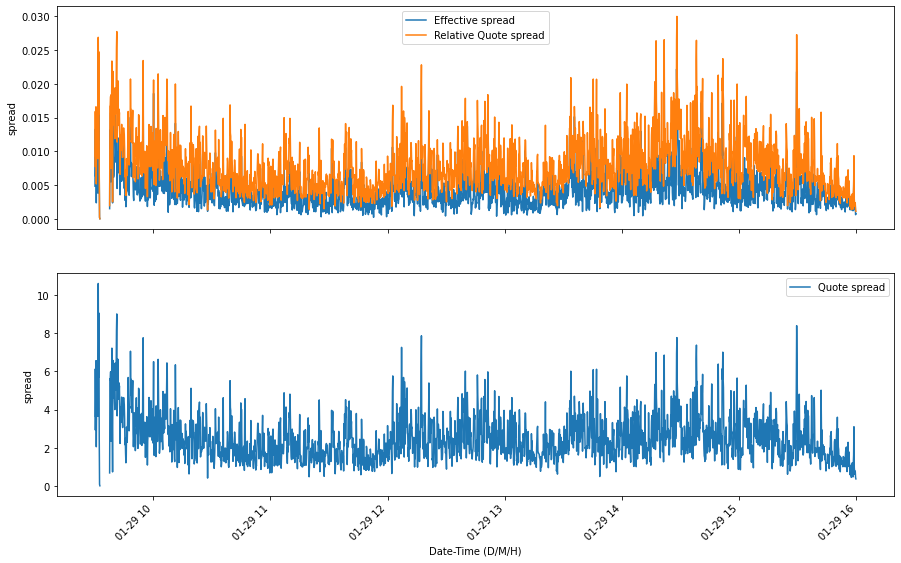

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.autofmt_xdate()
ax[0].plot(data_intvl['Date-Time'], data_intvl['intvl Effective spread'], label = 'Effective spread')
ax[0].plot(data_intvl['Date-Time'],data_intvl['intvl Relative Quote spread'], label = 'Relative Quote spread')
ax[0].legend()
plt.xlabel('Date-Time (D/M/H)')
plt.xticks(rotation=45)
ax[0].set_ylabel('spread')
ax[1].plot(data_intvl['Date-Time'],data_intvl['intvl Quote spread'], label = 'Quote spread')
ax[1].set_ylabel('spread')
ax[1].legend()


## Market efficiency Proxy

In [53]:
data2 = data[['Price', 'Tick Dir', 'Date-Time']]
data2 = data2.groupby('Tick Dir')
num_tick_ = data2.resample('10S', on='Date-Time').count()
num_tick_sum = data2.resample('10S', on='Date-Time').sum()
num_tick_sum
data_buyer = num_tick_.loc[1 , :]
data_seller = num_tick_.loc[-1 , :]
No_buyer = data_buyer['Tick Dir']
No_buyer = No_buyer.reset_index(level=0)
No_seller = data_seller['Tick Dir']
No_seller = No_seller.reset_index(level=0)
No_seller


data_buyer_sum = num_tick_sum.loc[1 , :]
data_seller_sum = num_tick_sum.loc[-1 , :]
dollar_buyer = data_buyer_sum['Price']
dollar_buyer = dollar_buyer.reset_index(level=0)
dollar_seller = data_seller_sum['Price']
dollar_seller = dollar_seller.reset_index(level=0)


In [54]:

data_intvl.insert(1, "No_buyer", No_buyer['Tick Dir'])
data_intvl.insert(1, "No_seller", No_seller['Tick Dir'])
data_intvl.insert(1, "dollar_buyer", dollar_buyer['Price'])
data_intvl.insert(1, "dollar_seller", dollar_seller['Price'])


In [55]:
data_intvl['OIB#'] = (data_intvl['No_buyer']-data_intvl['No_seller'])/(data_intvl['No_buyer']+data_intvl['No_seller'])
data_intvl['OIB$'] = (data_intvl['dollar_buyer']-data_intvl['dollar_seller'])/(data_intvl['dollar_buyer']+data_intvl['dollar_seller'])

In [56]:
data_intvl

,Date-Time,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$
0,2021-01-29 09:30:10-05:00,123036.82,167975.300,324,441,44310.00,116.528550,72.554008,14975.0,379.985,381.120,2.958932,0.007782,0.004845,0.152941,0.154421
1,2021-01-29 09:30:20-05:00,41767.89,269025.260,110,694,224082.95,581.999008,485.749662,36575.0,381.120,391.410,6.126670,0.015912,0.013281,0.726368,0.731217
2,2021-01-29 09:30:30-05:00,58932.04,236927.640,150,599,78377.35,198.914580,136.205062,21722.0,392.910,389.975,3.608201,0.009157,0.006270,0.599466,0.601622
3,2021-01-29 09:30:40-05:00,30433.50,208326.360,77,525,83197.56,210.454723,154.037134,12686.0,389.975,397.225,6.558219,0.016590,0.012142,0.744186,0.745070
4,2021-01-29 09:30:50-05:00,42393.72,162102.360,107,408,15624.23,39.374157,18.124133,7610.0,397.225,393.475,2.053118,0.005174,0.002382,0.584466,0.585384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,2021-01-29 15:59:10-05:00,69736.65,48732.190,212,148,7350.05,22.323057,16.168743,10013.0,329.475,328.995,0.734051,0.002229,0.001615,-0.177778,-0.177299
2335,2021-01-29 15:59:20-05:00,86228.85,49384.330,262,150,6768.06,20.546515,16.514068,10960.0,329.495,328.970,0.617524,0.001875,0.001507,-0.271845,-0.271688
2336,2021-01-29 15:59:30-05:00,83704.53,55855.095,255,170,15623.27,47.562471,39.606714,19954.0,328.970,328.235,0.782964,0.002384,0.001985,-0.200000,-0.199552
2337,2021-01-29 15:59:40-05:00,29884.31,38447.165,91,117,1670.53,5.083719,2.356957,3751.0,328.235,328.495,0.445356,0.001355,0.000628,0.125000,0.125313


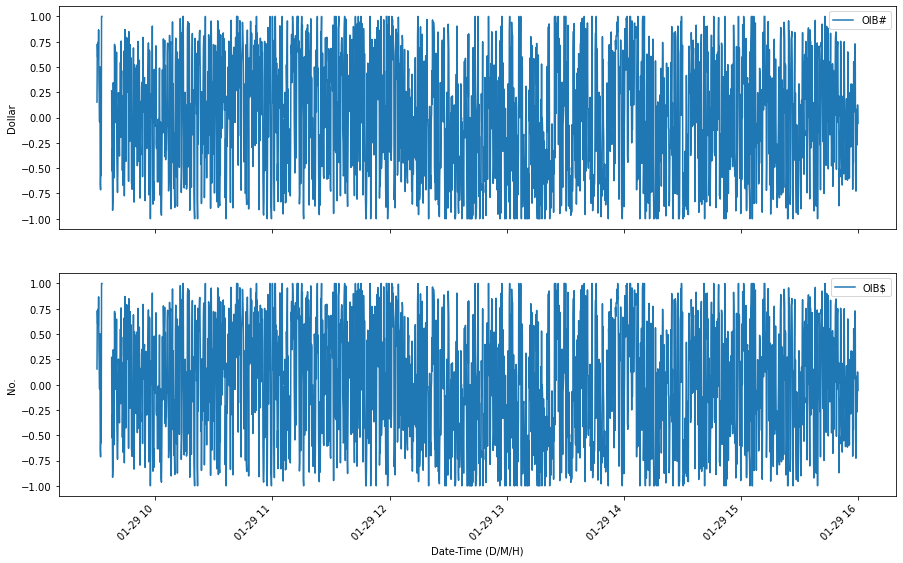

In [57]:
# plt.figure(figsize=(25,5))
# plt.plot(data_intvl['Date-Time'], data_intvl['OIB#'], label = 'OIB#')
# plt.plot(data_intvl['Date-Time'],data_intvl['OIB$'], label = 'OIB$')
# plt.legend()

fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.autofmt_xdate()
ax[0].plot(data_intvl['Date-Time'], data_intvl['OIB#'], label = 'OIB#')
ax[0].legend()
plt.xlabel('Date-Time (D/M/H)')
plt.xticks(rotation=45)
ax[0].set_ylabel('Dollar')
ax[1].plot(data_intvl['Date-Time'],data_intvl['OIB$'], label = 'OIB$')
ax[1].set_ylabel('No.')
ax[1].legend()

## Variance ratio

## Basic Regression

10 seconds returns are computed using the midpoints of the first and last quotes within each 10 seconds trading interval

In [58]:
# calculate return
# data_intvl['Returns'] = data_intvl['first_midquote']-data_intvl['last_midquote']
data_intvl['Returns'] = (data_intvl['last_midquote']/data_intvl['last_midquote'].shift(1))-1
data_intvl

,Date-Time,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
0,2021-01-29 09:30:10-05:00,123036.82,167975.300,324,441,44310.00,116.528550,72.554008,14975.0,379.985,381.120,2.958932,0.007782,0.004845,0.152941,0.154421,NaN
1,2021-01-29 09:30:20-05:00,41767.89,269025.260,110,694,224082.95,581.999008,485.749662,36575.0,381.120,391.410,6.126670,0.015912,0.013281,0.726368,0.731217,0.026999
2,2021-01-29 09:30:30-05:00,58932.04,236927.640,150,599,78377.35,198.914580,136.205062,21722.0,392.910,389.975,3.608201,0.009157,0.006270,0.599466,0.601622,-0.003666
3,2021-01-29 09:30:40-05:00,30433.50,208326.360,77,525,83197.56,210.454723,154.037134,12686.0,389.975,397.225,6.558219,0.016590,0.012142,0.744186,0.745070,0.018591
4,2021-01-29 09:30:50-05:00,42393.72,162102.360,107,408,15624.23,39.374157,18.124133,7610.0,397.225,393.475,2.053118,0.005174,0.002382,0.584466,0.585384,-0.009440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,2021-01-29 15:59:10-05:00,69736.65,48732.190,212,148,7350.05,22.323057,16.168743,10013.0,329.475,328.995,0.734051,0.002229,0.001615,-0.177778,-0.177299,-0.001457
2335,2021-01-29 15:59:20-05:00,86228.85,49384.330,262,150,6768.06,20.546515,16.514068,10960.0,329.495,328.970,0.617524,0.001875,0.001507,-0.271845,-0.271688,-0.000076
2336,2021-01-29 15:59:30-05:00,83704.53,55855.095,255,170,15623.27,47.562471,39.606714,19954.0,328.970,328.235,0.782964,0.002384,0.001985,-0.200000,-0.199552,-0.002234
2337,2021-01-29 15:59:40-05:00,29884.31,38447.165,91,117,1670.53,5.083719,2.356957,3751.0,328.235,328.495,0.445356,0.001355,0.000628,0.125000,0.125313,0.000792


### Descriptive statistics

In [59]:
# data_intvl = data_intvl[ np.isfinite( data_intvl ).all( axis = 1) ]
data_intvl.describe(include='float64')



,dollar_seller,dollar_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
count,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2339.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2310.000000,2308.000000
mean,13851.331293,12732.247316,7740.559230,24.064928,16.360881,2751.082514,317.638939,317.596485,2.505573,0.007976,0.004347,0.007829,0.008550,-0.000021
std,25123.861694,22091.258867,22496.351137,63.351659,54.452290,5047.140176,24.655920,24.631010,1.201316,0.003947,0.002824,0.595931,0.595912,0.007772
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,251.000000,250.995000,0.010000,0.000028,0.000028,-1.000000,-1.000000,-0.086470
25%,2847.885000,3150.090000,1308.290000,4.094724,1.784766,634.000000,303.551250,303.597500,1.661068,0.005155,0.002444,-0.514271,-0.513251,-0.002629
50%,6738.190000,7355.050000,3103.140000,9.903389,5.116939,1386.000000,321.870000,321.925000,2.252241,0.007211,0.003686,0.002538,0.005203,0.000093
75%,14757.675000,15029.190000,6873.865000,22.073375,13.176134,2812.500000,334.703750,334.660000,3.100004,0.009985,0.005443,0.531289,0.531678,0.002933
max,365799.870000,635464.140000,663773.270000,1660.688081,1532.854473,101384.000000,411.980000,411.980000,10.600376,0.029960,0.024567,1.000000,1.000000,0.083778


In [60]:

data_intvl.corr()

,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
dollar_seller,1.000000,0.371176,0.993998,0.364601,0.619102,0.650966,0.614045,0.660373,0.109489,0.057794,0.280030,0.239846,0.394351,-0.361509,-0.361133,-0.511148
dollar_buyer,0.371176,1.000000,0.341144,0.994603,0.399282,0.391405,0.348856,0.535455,0.173588,0.193701,0.134461,0.085717,0.159675,0.307248,0.307609,0.293777
No_seller,0.993998,0.341144,1.000000,0.338907,0.603730,0.644838,0.606245,0.664223,0.054068,0.002213,0.278597,0.251525,0.407393,-0.380020,-0.379668,-0.515843
No_buyer,0.364601,0.994603,0.338907,1.000000,0.382700,0.381147,0.335199,0.535778,0.120828,0.142860,0.133108,0.094840,0.167959,0.329980,0.330345,0.319936
Quote_spread_V,0.619102,0.399282,0.603730,0.382700,1.000000,0.991763,0.986453,0.822776,0.113330,0.095425,0.372261,0.316573,0.464962,-0.065297,-0.064904,-0.172504
Relative_Quote_spread_V,0.650966,0.391405,0.644838,0.381147,0.991763,1.000000,0.988595,0.846382,0.072631,0.053144,0.388440,0.342619,0.498821,-0.079162,-0.078775,-0.189331
Effective_spread_V,0.614045,0.348856,0.606245,0.335199,0.986453,0.988595,1.000000,0.832823,0.076636,0.055679,0.338359,0.293803,0.477036,-0.080333,-0.079997,-0.204701
Volume,0.660373,0.535455,0.664223,0.535778,0.822776,0.846382,0.832823,1.000000,0.083237,0.067656,0.140980,0.107507,0.311524,-0.049304,-0.049097,-0.157418
first_midquote,0.109489,0.173588,0.054068,0.120828,0.113330,0.072631,0.076636,0.083237,1.000000,0.995070,-0.098957,-0.283594,-0.204017,0.013124,0.013071,-0.057555
last_midquote,0.057794,0.193701,0.002213,0.142860,0.095425,0.053144,0.055679,0.067656,0.995070,1.000000,-0.106229,-0.289731,-0.220268,0.057490,0.057437,0.039602


In [61]:

#Define low liquidity of intvl effective sprerad < mean effective spread (0.007049)

data_intvl['ILD'] = 0
data_intvl.loc[(data_intvl['intvl Effective spread'] > 0.004347+0.002824), 'ILD'] = 1

# Create linear Regression model by using 2 X dimension i.e. OIB$(t-1) and OIB$(t-1)*ILD
# X = pd.DataFrame() 
# X['OIB'] = data_intvl['OIB#'].shift(1)
# X['OIBS'] = data_intvl['OIB$'].shift(1)
# X = X.drop(0, 0).reset_index().drop('index',1) 
# X['OIBSILD'] = X['OIBS']*data_intvl['ILD']
# X.dropna(inplace=True)
# X = X[ np.isfinite( X ).all( axis = 1) ]
# y = pd.DataFrame()
# y['Returns'] = data_intvl['Returns']
# y = y[ np.isfinite( y ).all( axis = 1) ]
# trn = X.merge(y, left_index=True, right_index=True)

# X_train = trn.drop('Returns',1)
# y_train = trn["Returns"]

# Create linear Regression model by using 2 X dimension i.e. OIB$(t-1) and OIB$(t-1)*ILD
X = pd.DataFrame() 
X['OIB'] = data_intvl['OIB$'].shift(1)
X = X.drop(0, 0).reset_index().drop('index',1) 
X['OIBILD'] = X['OIB']*data_intvl['ILD']
X = X[ np.isfinite( X ).all( axis = 1) ]
y = pd.DataFrame()
y['Returns'] = data_intvl['Returns']
y = y[ np.isfinite( y ).all( axis = 1) ]
trn = X.merge(y, left_index=True, right_index=True)

X_train = trn.drop('Returns',1)
y_train = trn["Returns"]


#Create linear regression model

linr =  LinearRegression().fit(X_train, y_train)
r_square = linr.score(X_train, y_train)
r_square
#Create linear regression model

linr =  LinearRegression().fit(X_train, y_train)
r_square = linr.score(X_train, y_train)
r_square




0.2481754293988898

In [62]:
# CALCULATE the ESPR in liquid and illiquidity day
data_intvl.groupby('ILD').mean()


,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
ILD,,,,,,,,,,,,,,,,
0,10959.607788,11591.698784,34.434655,35.894273,4733.052227,14.860749,8.900142,2280.610866,318.838560,318.912296,2.229988,0.007059,0.003516,0.035187,0.035844,0.000317
1,33810.085084,20604.344105,106.712838,63.283784,28498.453851,87.592418,67.855103,5998.290541,309.476655,308.643632,4.380669,0.014215,0.009999,-0.178316,-0.177164,-0.002321


In [63]:
data_intvl.groupby('ILD').std()

,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
ILD,,,,,,,,,,,,,,,,
0,17940.857273,20230.308169,55.519486,58.456850,7365.499812,22.852852,16.424589,3735.509353,23.268365,23.275768,0.910937,0.002998,0.001570,0.575823,0.575806,0.005981
1,48134.768840,31042.826597,143.636861,86.277836,56039.523059,153.482832,136.329837,9653.289213,31.417561,30.976289,1.259764,0.003975,0.002972,0.690823,0.690925,0.014915


In [64]:
data_intvl.groupby('ILD').count()

,Date-Time,dollar_seller,dollar_buyer,No_seller,No_buyer,Quote_spread_V,Relative_Quote_spread_V,Effective_spread_V,Volume,first_midquote,last_midquote,intvl Quote spread,intvl Relative Quote spread,intvl Effective spread,OIB#,OIB$,Returns
ILD,,,,,,,,,,,,,,,,,
0,2043,2043,2043,2043,2043,2043,2043,2043,2043,2014,2014,2014,2014,2014,2014,2014,2012
1,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296,296


In [65]:
from statsmodels.formula.api import ols
lm1 = ols('Returns~ OIB',data=trn).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     589.2
Date:                Sat, 09 Apr 2022   Prob (F-statistic):          4.34e-116
Time:                        20:32:16   Log-Likelihood:                 8194.7
No. Observations:                2307   AIC:                        -1.639e+04
Df Residuals:                    2305   BIC:                        -1.637e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.005e-05      0.000     -0.485      0.628      -0.000       0.000
OIB            0.0059      0.000     24.273      0.000       0.005       0.006
==============================================================================
Omnibus:                      659.171   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51927.774
Skew:                          -0.354   Prob(JB):                         0.00
Kurtosis:                      26.232   Cond. No.                         1.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
lm2 = ols('Returns~ OIB+OIBILD',data=trn).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     380.3
Date:                Sat, 09 Apr 2022   Prob (F-statistic):          1.93e-143
Time:                        20:32:16   Log-Likelihood:                 8261.2
No. Observations:                2307   AIC:                        -1.652e+04
Df Residuals:                    2304   BIC:                        -1.650e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.000      0.735      0.463      -0.000       0.000
OIB            0.0046      0.000     17.502      0.000       0.004       0.005
OIBILD         0.0072      0.001     11.691      0.000       0.006       0.008
==============================================================================
Omnibus:                      616.888   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47266.150
Skew:                          -0.196   Prob(JB):                         0.00
Kurtosis:                      25.171   Cond. No.                         4.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
trn.corr()

,OIB,OIBILD,Returns
OIB,1.000000,0.430873,0.451189
OIBILD,0.430873,1.000000,0.384991
Returns,0.451189,0.384991,1.000000


In [69]:
trn = X.merge(data_intvl['intvl Effective spread'], left_index=True, right_index=True)
trn = X.merge(data_intvl['intvl Effective spread'], left_index=True, right_index=True)
trn
# test if the intvl Effective spread is predictive of the future OIB$ in (100s)
grangercausalitytests(trn[['OIBILD', 'intvl Effective spread']], maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5420  , p=0.0186  , df_denom=2305, df_num=1
ssr based chi2 test:   chi2=5.5492  , p=0.0185  , df=1
likelihood ratio test: chi2=5.5426  , p=0.0186  , df=1
parameter F test:         F=5.5420  , p=0.0186  , df_denom=2305, df_num=1


{1: ({'ssr_ftest': (5.5420291826515635, 0.018648534469437365, 2305.0, 1),
   'ssr_chi2test': (5.549242235817704, 0.018488689495630477, 1),
   'lrtest': (5.54258174656843, 0.018559183229713887, 1),
   'params_ftest': (5.5420291826484585, 0.0186485344694741, 2305.0, 1.0)},
   array([[0., 1., 0.]])])}

In [71]:
grangercausalitytests(trn[['intvl Effective spread','OIBILD' ]], maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4157  , p=0.0647  , df_denom=2305, df_num=1
ssr based chi2 test:   chi2=3.4201  , p=0.0644  , df=1
likelihood ratio test: chi2=3.4176  , p=0.0645  , df=1
parameter F test:         F=3.4157  , p=0.0647  , df_denom=2305, df_num=1


{1: ({'ssr_ftest': (3.415668789991501, 0.06470825892937895, 2305.0, 1),
   'ssr_chi2test': (3.4201143459003838, 0.06440655198800266, 1),
   'lrtest': (3.4175827949256927, 0.06450539895066114, 1),
   'params_ftest': (3.4156687899917, 0.06470825892935875, 2305.0, 1.0)},
   array([[0., 1., 0.]])])}